In [3]:
import os
import pickle

EXPERIMENTS_DIRECTORY = os.path.join(
    "experiments",
)

evo_experiments = [directory for directory in os.listdir(EXPERIMENTS_DIRECTORY) if directory.lower().startswith("evo")]
filenames = ["all_objective_metrics.pkl", "all_genome_metrics.pkl", "all_archives.pkl"]



In [4]:
experiment_metrics = {}
for experiment_dir in evo_experiments:
    results = []
    for filename in filenames:
        try:
            with open(os.path.join(EXPERIMENTS_DIRECTORY, experiment_dir, filename), "rb") as infile:
                data = pickle.load(infile)
                results.append(data)
        except Exception as e:
            print(f"Error {e} Skipping:", filename, "for directory:", experiment_dir)
    experiment_metrics[experiment_dir] = results
    break

print(experiment_metrics)

    

2024-11-25 14:15:26.145279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 14:15:26.231621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 14:15:26.266242: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 14:15:26.412484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 14:15:31.609287: W tensorflow/comp

{'evo_lenet_mnist_10_experiments_8-relu_layers_10-asize_50-psize_2-nfronts_4-tsize_2-nwinners_0.5-mscale_0.5-mrate_20241122-133156': [[{'objective_0_value': array([[0.08      , 0.13      ],
       [0.08      , 0.1       ],
       [0.09      , 0.18000001],
       [0.08      , 0.08      ],
       [0.08      , 0.12      ],
       [0.08      , 0.19      ],
       [0.19      , 0.12      ],
       [0.14      , 0.15000001],
       [0.14      , 0.23      ],
       [0.13      , 0.12      ],
       [0.19      , 0.17      ],
       [0.14      , 0.14      ],
       [0.09      , 0.23999999],
       [0.05      , 0.20999999],
       [0.17      , 0.16      ],
       [0.15000001, 0.11      ],
       [0.19      , 0.20999999],
       [0.06      , 0.19      ],
       [0.07      , 0.16      ],
       [0.05      , 0.12      ],
       [0.09      , 0.19      ],
       [0.16      , 0.18000001],
       [0.19      , 0.16      ],
       [0.19      , 0.12      ],
       [0.08      , 0.19      ],
       [0.06      

In [86]:
key = list(experiment_metrics.keys())[0]
all_objective_metrics = experiment_metrics[key][0]
all_genome_metrics = experiment_metrics[key][1]
all_archive_metrics = experiment_metrics[key][2]

In [104]:
print(len(all_objective_metrics))
print(np.shape(np.array((all_objective_metrics[0]["objective_0_value"]))))
print(np.mean([np.mean(e["objective_0_value"], axis=0) for e in all_objective_metrics], axis=0))
print(np.mean([np.std(e["objective_0_value"], axis=0) for e in all_objective_metrics], axis=0))

10
(50, 2)
[0.1276 0.1274]
[0.02915587 0.02492249]


In [105]:
import numpy as np
import numpy.typing as npt
from typing import Dict, List, Tuple

def agg_objective_metrics(
    objective_metrics: List[Dict[str, npt.NDArray[npt.NDArray[np.float64]]]]
) -> Tuple[npt.NDArray[npt.NDArray[np.float64]]]:
    agg_accuracy_values = np.mean([np.mean(e["objective_0_value"], axis=0) for e in all_objective_metrics], axis=0)
    agg_sparsity_values = np.mean([np.mean(e["objective_1_value"], axis=0) for e in all_objective_metrics], axis=0)
    std_accuracy_values = np.mean([np.std(e["objective_0_value"], axis=0) for e in all_objective_metrics], axis=0)
    std_sparsity_values = np.mean([np.std(e["objective_1_value"], axis=0) for e in all_objective_metrics], axis=0)
    return agg_accuracy_values, agg_sparsity_values, std_accuracy_values, std_sparsity_values

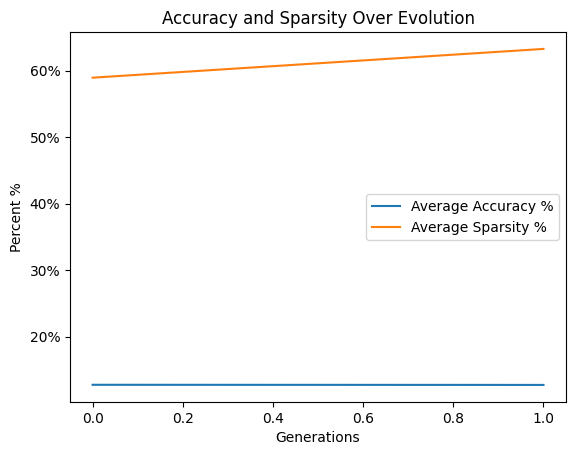

In [117]:
from matplotlib import pyplot as plt

agg_accuracy_values, agg_sparsity_values, std_accuracy_values, std_sparsity_values = map(lambda x: x * 100, agg_objective_metrics(all_objective_metrics))
generations = np.arange(len(agg_sparsity_values))

plt.title("Accuracy and Sparsity Over Evolution")
plt.plot(generations, agg_accuracy_values, label="Average Accuracy %")
plt.plot(generations, agg_sparsity_values, label="Average Sparsity %")
plt.xlabel("Generations")
plt.ylabel("Percent %")
plt.legend()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.show()

In [1]:
import src.harness.evolution as evo
import functools
from tensorflow import keras

model_feature_selectors = [
    evo.ModelFeatures.layer_sparsity, 
    evo.ModelFeatures.magnitude,
    evo.ModelFeatures.random,
    functools.partial(evo.ModelFeatures.synaptic_flow, loss_fn=keras.losses.CategoricalCrossentropy()),
]
arch_feature_selectors = [
    evo.ArchFeatures.layer_num,
    evo.ArchFeatures.layer_ohe,
    evo.ArchFeatures.layer_prop_params,
]

hidden_layer_sizes = []
hidden_layer_activations = []

layers = list(zip(hidden_layer_sizes, hidden_layer_activations))

individual_constructor = functools.partial(
    evo.Individual, 
    architecture_name="lenet",
    dataset_name="mnist",
    model_feature_selectors=model_feature_selectors,
    arch_feature_selectors=arch_feature_selectors,
    layers=layers,
)

def random_restart(population_size: int, num_generations: int) -> Tuple[npt.NDArray[np.float64]]:
    accuracies = np.zeros((population_size, num_generations))
    sparsities = np.zeros((population_size, num_generations))
    for generation_index in range(num_generations):
        individuals = [individual_constructor() for _ in range(population_size)]
        for individual_index, individual in enumerate(individuals):
            accuracy = evo.Individual.eval_accuracy(individual)
            sparsity = evo.Individual.sparsity(individual)
            accuracies[individual_index][generation_index] = accuracy
            sparsities[individual_index][generation_index] = sparsity
    return accuracies, sparsities

random_accuracies, random_sparsities = random_restart(50, 100)
        
        
    

2024-11-25 19:16:02.363066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 19:16:02.452235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 19:16:02.480757: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 19:16:02.573757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 19:16:06.145715: W tensorflow/comp

NameError: name 'Tuple' is not defined